# **Reinforcement Learning: Taller 4**
## Estudiantes: Juan Pablo Reyes Fajardo y Santiago Rodríguez Ávila 

## Discretización

Inicialmente se realizan múltiples experimentos para determinar límites razonables para las variables a discretizar (aquellas cuyo espacio de observación es infinito)

In [7]:
velocidades_absolutas_maximas={"Lineal":[],"Angular":[]}

observation = env.reset()

abs_lineal=abs(observation[1])
abs_angular=abs(observation[3])

for _ in range(int(1e6)):
    
    action = env.action_space.sample()  # agent policy that uses the observation and info
    observation, reward, terminated, truncated= env.step(action)
    
    if abs(observation[1])>abs_lineal:
        abs_lineal=abs(observation[1])
    if abs(observation[3])>abs_angular:
        abs_angular=abs(observation[3])

    if terminated or truncated:
        observation = env.reset()
        velocidades_absolutas_maximas["Lineal"].append(abs_lineal)
        velocidades_absolutas_maximas["Angular"].append(abs_angular)

env.close()

vel_lin_abs_max=np.mean(velocidades_absolutas_maximas["Lineal"])
vel_ang_abs_max=np.mean(velocidades_absolutas_maximas["Angular"])
print(f'Promedio de velocidad lineal absoluta máxima: \
      {vel_lin_abs_max} \
      \nPromedio de velocidad angular absoluta máxima: \
      {vel_ang_abs_max}')

Promedio de velocidad lineal absoluta máxima:       3.3262861187659625       
Promedio de velocidad angular absoluta máxima:       3.5935304180705443


Discretización de estados:

In [8]:
# Límites del espacio de observación del MDP real
cart_high_var = env.observation_space.high
cart_low_var = env.observation_space.low

# Espacios de observación discretizados
observation_space_discrete_400=[np.linspace(cart_low_var[0], cart_high_var[0], num= 5),\
                            np.linspace(-vel_lin_abs_max, vel_lin_abs_max, num= 4),\
                            np.linspace(cart_low_var[2], cart_high_var[2], num = 5),\
                            np.linspace(-vel_ang_abs_max, vel_ang_abs_max, num= 4)]\

observation_space_discrete_4096=[np.linspace(cart_low_var[0], cart_high_var[0], num= 8),\
                            np.linspace(-vel_lin_abs_max, vel_lin_abs_max, num= 8),\
                            np.linspace(cart_low_var[2], cart_high_var[2], num = 8),\
                            np.linspace(-vel_ang_abs_max, vel_ang_abs_max, num= 8)]

# Uso de iteradores para obtener todos los estados a partir del espacio de obsevación discreto
states_400=list(itertools.product(*observation_space_discrete_400))
states_4096=list(itertools.product(*observation_space_discrete_4096))

def init_Q_400():
    Q_table={}
    for i in states_400:
        Q_table[i] = {0:0,1:0}
    return Q_table

def init_Q_4096():
    Q_table={}
    for i in states_4096:
        Q_table[i] = {0:0,1:0}
    return Q_table
         
def discretize_400(new_state):
    # car pos, car vel, pole angle, pole vel
    discretizacion=[0]*4
    for i in range(len(discretizacion)):
        dif = [(abs(x - new_state[i])) for x in observation_space_discrete_400[i]]
        discretizacion[i] = observation_space_discrete_400[i][dif.index(min(dif))]
        
    return tuple(discretizacion)

def discretize_4096(new_state):
    # car pos, car vel, pole angle, pole vel
    discretizacion=[0]*4
    for i in range(len(discretizacion)):
        dif = [(abs(x - new_state[i])) for x in observation_space_discrete_4096[i]]
        discretizacion[i] = observation_space_discrete_4096[i][dif.index(min(dif))]
        
    return tuple(discretizacion)

## Estimación de Q con Q-Learning 

### Implementación de los algoritmos

#### Q-learning con 400 estados

In [20]:
def Q_Learning_400(gamma,alpha):
    terminated=False
    observation, info = env.reset()
    observation=discretize_400(observation)
    while not terminated:
        
        action,_=eps_greedy(Q,observation,0.1)
        
        observation_, reward, terminated, truncated, info = env.step(action)
        observation_=discretize_400(observation_)
        
        Q_=key_max(Q[observation_])[1]

        Q[observation][action]+=alpha*(reward+gamma*Q_-Q[observation][action])
        observation=observation_

##### Entrenamiento de Q-learning con 400 estados

In [ ]:
env = gym.make('CartPole-v1',render_mode='human')
Q=init_Q_400()
policy=dict.fromkeys(states_400, 0)
for i in range(int(1e3)):
    Q_Learning_400(0.9,0.1)

##### Prueba de política encontrada

In [ ]:
for state_400 in states_400:
    policy[state_400],_=eps_greedy(Q,tuple(state_400),0)

In [ ]:
env = gym.make('CartPole-v1',render_mode="human")

rwds=[]
for _ in range(100):
    observation = env.reset()
    r=0
    while True:
        action = policy[discretize_400(observation)]
        observation, reward, terminated, truncated= env.step(action)
        r+=reward

        if terminated or truncated:
            observation = env.reset()
            rwds.append(r)
            break
env.close()
print(np.mean(rwds))

#### Q-learning con 4096 estados

In [ ]:
def Q_Learning_4096(gamma,alpha):
    terminated=False
    observation, info = env.reset()
    observation=discretize_4096(observation)
    while not terminated:
        
        action,_=eps_greedy(Q,observation,0.1)
        
        observation_, reward, terminated, truncated, info = env.step(action)
        observation_=discretize_4096(observation_)
        
        Q_=key_max(Q[observation_])[1]

        Q[observation][action]+=alpha*(reward+gamma*Q_-Q[observation][action])
        observation=observation_

##### Entrenamiento de Q-learning con 4096 estados

In [ ]:
env = gym.make('CartPole-v1')
Q=init_Q_4096()
policy=dict.fromkeys(states_4096, 0)
    
for i in tqdm(range(int(1e6))):
    Q_Learning_4096(0.9,0.1)

##### Prueba de política encontrada

In [ ]:
for state_4096 in states_4096:
    policy[state_4096],_=eps_greedy(Q,tuple(state_4096),0)

In [ ]:

env = gym.make('CartPole-v1',render_mode="human")


rwds=[]
for _ in range(100):
    observation, info = env.reset()
    r=0
    while True:
        action = policy[discretize_4096(observation)]
        observation, reward, terminated, truncated, info = env.step(action)
        r+=reward

        if terminated or truncated:
            observation, info = env.reset()
            rwds.append(r)
            break
env.close()
print(np.mean(rwds))

## Estimación de Q con SARSA

In [75]:
import gym
import numpy as np
def SARSA_400(gamma,alpha):
    terminated=False
    observation = env.reset()
    observation=discretize_400(observation)
    action,_=eps_greedy(Q,observation,0.1)
    G = 0
    while not terminated:         
        #env.render(mode='human')
        observation_, reward, terminated, truncated = env.step(action)
        observation_=discretize_400(observation_)
        G+=reward
        action_,_ = eps_greedy(Q,observation_,0.1)
          
        Q_ = Q[observation_][action_]
        Q[observation][action]+=alpha*(reward+gamma*Q_-Q[observation][action])
        observation=observation_
        action = action_
    return G

def SARSA_4096(gamma,alpha):
    terminated=False
    observation = env.reset()
    observation=discretize_4096(observation)
    action,_=eps_greedy(Q,observation,0.1)
    G = 0
    while not terminated:         
        #env.render(mode='human')
        observation_, reward, terminated, truncated = env.step(action)
        observation_=discretize_4096(observation_)
        G+=reward
        action_,_ = eps_greedy(Q,observation_,0.1)
          
        Q_ = Q[observation_][action_]
        Q[observation][action]+=alpha*(reward+gamma*Q_-Q[observation][action])
        observation=observation_
        action = action_
    return G



In [78]:
env = gym.make('CartPole-v0')

Q=init_Q_4096()
policy=dict.fromkeys(states_400, 0)
Gs=[]
for i in tqdm(range(0,int(2e5))):
    Gs.append(SARSA_4096(0.9,0.3))
    

100%|██████████| 200000/200000 [17:48<00:00, 187.20it/s]


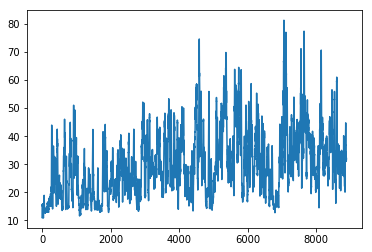

In [77]:
plt.plot(running_mean(Gs,20))
plt.show()

## Redes neuronales: DQN

In [4]:
import numpy as np
import gym

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.agents.sarsa import SARSAAgent
from rl.policy import EpsGreedyQPolicy
from rl.memory import SequentialMemory


from rl.callbacks import Callback

class EpisodeRewardCallback(Callback):
    def __init__(self):
        super(EpisodeRewardCallback, self).__init__()
        self.episode_rewards = []

    def on_episode_end(self, episode, logs):
        episode_reward = logs['episode_reward']
        self.episode_rewards.append(episode_reward)
        print(f"Episode {episode + 1} reward: {episode_reward}")

# Create an instance of the callback
episode_callback = EpisodeRewardCallback()

#### Red neuronal con 4 capas

##### Creación de la estructura de la red 

In [11]:
# Next, we build a very simple model.
model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(4))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())

# Finally, we configure and compile our agent. You can use every built-in Keras optimizer and
# even the metrics!
memory = SequentialMemory(limit=int(1e5), window_length=1)
policy = EpsGreedyQPolicy()

dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=10,
               target_model_update=1e-2, policy=policy)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

# Okay, now it's time to learn something! We visualize the training here for show, but this
# slows down training quite a lot. You can always safely abort the training prematurely using
# Ctrl + C.

dqn.fit(env, nb_steps=int(0.5e5), visualize=False, verbose=2,callbacks=[episode_callback])

# After training is done, we save the final weights.
dqn.save_weights('dqn_{}_weights.h5f'.format(ENV_NAME), overwrite=True)

# Finally, evaluate our algorithm for 5 episodes.
dqn.test(env, nb_episodes=5, visualize=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 4)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 20        
_________________________________________________________________
activation_5 (Activation)    (None, 4)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 10        
_________________________________________________________________
activation_6 (Activation)    (None, 2)                 0         
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
None
Training for 50000 steps ...


/opt/conda/lib/python3.6/site-packages/rl/memory.py:39: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


Episode 1 reward: 18.0
    18/50000: episode: 1, duration: 3.182s, episode steps: 18, steps per second: 6, episode reward: 18.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.222 [0.000, 1.000], mean observation: 0.089 [-1.911, 3.038], loss: 0.525403, mean_absolute_error: 0.609027, mean_q: 0.157265
Episode 2 reward: 10.0
    28/50000: episode: 2, duration: 0.056s, episode steps: 10, steps per second: 177, episode reward: 10.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.100 [0.000, 1.000], mean observation: 0.142 [-1.584, 2.535], loss: 0.501773, mean_absolute_error: 0.690525, mean_q: 0.343458
Episode 3 reward: 11.0
    39/50000: episode: 3, duration: 0.125s, episode steps: 11, steps per second: 88, episode reward: 11.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.091 [0.000, 1.000], mean observation: 0.140 [-1.729, 2.842], loss: 0.543891, mean_absolute_error: 0.711402, mean_q: 0.415334


/opt/conda/lib/python3.6/site-packages/rl/memory.py:39: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')
/opt/conda/lib/python3.6/site-packages/rl/memory.py:39: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


Episode 4 reward: 11.0
    50/50000: episode: 4, duration: 0.176s, episode steps: 11, steps per second: 62, episode reward: 11.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.182 [0.000, 1.000], mean observation: 0.099 [-1.594, 2.377], loss: 0.508113, mean_absolute_error: 0.711618, mean_q: 0.501309
Episode 5 reward: 12.0
    62/50000: episode: 5, duration: 0.298s, episode steps: 12, steps per second: 40, episode reward: 12.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.083 [0.000, 1.000], mean observation: 0.101 [-1.967, 3.026], loss: 0.581797, mean_absolute_error: 0.746358, mean_q: 0.567454
Episode 6 reward: 10.0
    72/50000: episode: 6, duration: 0.231s, episode steps: 10, steps per second: 43, episode reward: 10.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.000 [0.000, 0.000], mean observation: 0.125 [-1.989, 3.032], loss: 0.485018, mean_absolute_error: 0.723542, mean_q: 0.632521
Episode 7 reward: 10.0
    82/50000: episode: 7, duration: 0.113s, episode step

Episode 33 reward: 11.0
   336/50000: episode: 33, duration: 0.053s, episode steps: 11, steps per second: 208, episode reward: 11.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.273 [0.000, 1.000], mean observation: 0.118 [-1.385, 2.132], loss: 0.435237, mean_absolute_error: 0.698736, mean_q: 2.177992
Episode 34 reward: 10.0
   346/50000: episode: 34, duration: 0.048s, episode steps: 10, steps per second: 208, episode reward: 10.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.000 [0.000, 0.000], mean observation: 0.123 [-1.983, 3.040], loss: 0.491093, mean_absolute_error: 0.729872, mean_q: 2.347464
Episode 35 reward: 10.0
   356/50000: episode: 35, duration: 0.044s, episode steps: 10, steps per second: 227, episode reward: 10.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.000 [0.000, 0.000], mean observation: 0.143 [-1.960, 3.121], loss: 0.456943, mean_absolute_error: 0.767716, mean_q: 2.350129
Episode 36 reward: 8.0
   364/50000: episode: 36, duration: 0.036s, ep

Episode 61 reward: 9.0
   607/50000: episode: 61, duration: 0.046s, episode steps: 9, steps per second: 197, episode reward: 9.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.111 [0.000, 1.000], mean observation: 0.155 [-1.339, 2.292], loss: 0.701027, mean_absolute_error: 1.702338, mean_q: 3.675664
Episode 62 reward: 12.0
   619/50000: episode: 62, duration: 0.059s, episode steps: 12, steps per second: 205, episode reward: 12.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.167 [0.000, 1.000], mean observation: 0.130 [-1.717, 2.703], loss: 0.645669, mean_absolute_error: 1.717142, mean_q: 3.756910
Episode 63 reward: 11.0
   630/50000: episode: 63, duration: 0.050s, episode steps: 11, steps per second: 219, episode reward: 11.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.182 [0.000, 1.000], mean observation: 0.105 [-1.363, 2.167], loss: 0.579195, mean_absolute_error: 1.739275, mean_q: 3.811497
Episode 64 reward: 10.0
   640/50000: episode: 64, duration: 0.047s, epis

Episode 89 reward: 10.0
   878/50000: episode: 89, duration: 0.101s, episode steps: 10, steps per second: 99, episode reward: 10.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.100 [0.000, 1.000], mean observation: 0.112 [-1.806, 2.706], loss: 0.627181, mean_absolute_error: 2.400271, mean_q: 4.694975
Episode 90 reward: 10.0
   888/50000: episode: 90, duration: 0.054s, episode steps: 10, steps per second: 185, episode reward: 10.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.200 [0.000, 1.000], mean observation: 0.119 [-1.388, 2.274], loss: 0.575659, mean_absolute_error: 2.375905, mean_q: 4.762807
Episode 91 reward: 10.0
   898/50000: episode: 91, duration: 0.055s, episode steps: 10, steps per second: 183, episode reward: 10.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.200 [0.000, 1.000], mean observation: 0.122 [-1.375, 2.195], loss: 0.521802, mean_absolute_error: 2.350314, mean_q: 4.804580
Episode 92 reward: 10.0
   908/50000: episode: 92, duration: 0.057s, ep

Episode 118 reward: 8.0
  1160/50000: episode: 118, duration: 0.136s, episode steps: 8, steps per second: 59, episode reward: 8.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.000 [0.000, 0.000], mean observation: 0.150 [-1.558, 2.503], loss: 0.328562, mean_absolute_error: 2.474088, mean_q: 5.649667
Episode 119 reward: 10.0
  1170/50000: episode: 119, duration: 0.562s, episode steps: 10, steps per second: 18, episode reward: 10.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.200 [0.000, 1.000], mean observation: 0.114 [-1.548, 2.361], loss: 0.408543, mean_absolute_error: 2.449751, mean_q: 5.397416
Episode 120 reward: 9.0
  1179/50000: episode: 120, duration: 0.464s, episode steps: 9, steps per second: 19, episode reward: 9.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.222 [0.000, 1.000], mean observation: 0.131 [-1.389, 2.195], loss: 0.417787, mean_absolute_error: 2.485466, mean_q: 5.496596
Episode 121 reward: 15.0
  1194/50000: episode: 121, duration: 0.941s, ep

Episode 145 reward: 10.0
  1430/50000: episode: 145, duration: 0.377s, episode steps: 10, steps per second: 27, episode reward: 10.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.300 [0.000, 1.000], mean observation: 0.122 [-1.410, 2.118], loss: 0.273537, mean_absolute_error: 2.725911, mean_q: 6.013525
Episode 146 reward: 14.0
  1444/50000: episode: 146, duration: 0.235s, episode steps: 14, steps per second: 60, episode reward: 14.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.286 [0.000, 1.000], mean observation: 0.083 [-1.558, 2.218], loss: 0.301115, mean_absolute_error: 2.714504, mean_q: 5.879927
Episode 147 reward: 11.0
  1455/50000: episode: 147, duration: 0.170s, episode steps: 11, steps per second: 65, episode reward: 11.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.273 [0.000, 1.000], mean observation: 0.108 [-1.579, 2.301], loss: 0.256721, mean_absolute_error: 2.795501, mean_q: 6.086590
Episode 148 reward: 9.0
  1464/50000: episode: 148, duration: 0.089

Episode 175 reward: 10.0
  1738/50000: episode: 175, duration: 0.085s, episode steps: 10, steps per second: 117, episode reward: 10.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.400 [0.000, 1.000], mean observation: 0.120 [-0.939, 1.562], loss: 0.244608, mean_absolute_error: 3.080693, mean_q: 6.298001
Episode 176 reward: 11.0
  1749/50000: episode: 176, duration: 0.111s, episode steps: 11, steps per second: 99, episode reward: 11.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.364 [0.000, 1.000], mean observation: 0.103 [-1.215, 1.836], loss: 0.349734, mean_absolute_error: 3.165167, mean_q: 6.366631
Episode 177 reward: 12.0
  1761/50000: episode: 177, duration: 0.062s, episode steps: 12, steps per second: 195, episode reward: 12.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.500 [0.000, 1.000], mean observation: 0.097 [-1.141, 1.755], loss: 0.275386, mean_absolute_error: 3.205772, mean_q: 6.499735
Episode 178 reward: 11.0
  1772/50000: episode: 178, duration: 0.

Episode 202 reward: 29.0
  2223/50000: episode: 202, duration: 0.746s, episode steps: 29, steps per second: 39, episode reward: 29.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.690 [0.000, 1.000], mean observation: -0.036 [-3.261, 2.350], loss: 0.678664, mean_absolute_error: 3.782758, mean_q: 7.243977
Episode 203 reward: 26.0
  2249/50000: episode: 203, duration: 0.148s, episode steps: 26, steps per second: 176, episode reward: 26.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.769 [0.000, 1.000], mean observation: 0.028 [-3.530, 2.698], loss: 0.601624, mean_absolute_error: 3.913749, mean_q: 7.507391
Episode 204 reward: 26.0
  2275/50000: episode: 204, duration: 0.180s, episode steps: 26, steps per second: 144, episode reward: 26.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.769 [0.000, 1.000], mean observation: 0.007 [-3.695, 2.724], loss: 1.411383, mean_absolute_error: 4.034016, mean_q: 7.618400
Episode 205 reward: 32.0
  2307/50000: episode: 205, duration: 0

Episode 229 reward: 20.0
  2866/50000: episode: 229, duration: 0.342s, episode steps: 20, steps per second: 59, episode reward: 20.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.800 [0.000, 1.000], mean observation: -0.017 [-3.245, 2.356], loss: 2.200582, mean_absolute_error: 5.087604, mean_q: 9.456463
Episode 230 reward: 23.0
  2889/50000: episode: 230, duration: 0.402s, episode steps: 23, steps per second: 57, episode reward: 23.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.783 [0.000, 1.000], mean observation: -0.014 [-3.513, 2.501], loss: 2.226658, mean_absolute_error: 5.121396, mean_q: 9.537394
Episode 231 reward: 29.0
  2918/50000: episode: 231, duration: 0.385s, episode steps: 29, steps per second: 75, episode reward: 29.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.724 [0.000, 1.000], mean observation: 0.001 [-3.293, 2.503], loss: 3.055028, mean_absolute_error: 5.104170, mean_q: 9.349550
Episode 232 reward: 32.0
  2950/50000: episode: 232, duration: 0.

Episode 257 reward: 24.0
  3725/50000: episode: 257, duration: 0.159s, episode steps: 24, steps per second: 151, episode reward: 24.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.750 [0.000, 1.000], mean observation: -0.019 [-3.313, 2.361], loss: 2.297327, mean_absolute_error: 5.812541, mean_q: 10.844486
Episode 258 reward: 46.0
  3771/50000: episode: 258, duration: 0.239s, episode steps: 46, steps per second: 192, episode reward: 46.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.630 [0.000, 1.000], mean observation: -0.026 [-3.240, 2.293], loss: 2.339294, mean_absolute_error: 5.912387, mean_q: 11.019696
Episode 259 reward: 35.0
  3806/50000: episode: 259, duration: 0.209s, episode steps: 35, steps per second: 167, episode reward: 35.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.686 [0.000, 1.000], mean observation: -0.005 [-3.360, 2.463], loss: 2.444074, mean_absolute_error: 5.920562, mean_q: 11.058417
Episode 260 reward: 24.0
  3830/50000: episode: 260, durat

Episode 285 reward: 29.0
  4531/50000: episode: 285, duration: 0.188s, episode steps: 29, steps per second: 154, episode reward: 29.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.690 [0.000, 1.000], mean observation: -0.052 [-3.140, 2.115], loss: 2.106397, mean_absolute_error: 6.505031, mean_q: 12.224994
Episode 286 reward: 18.0
  4549/50000: episode: 286, duration: 0.099s, episode steps: 18, steps per second: 183, episode reward: 18.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.778 [0.000, 1.000], mean observation: -0.055 [-2.943, 1.975], loss: 2.478363, mean_absolute_error: 6.553591, mean_q: 12.244757
Episode 287 reward: 27.0
  4576/50000: episode: 287, duration: 0.198s, episode steps: 27, steps per second: 136, episode reward: 27.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.667 [0.000, 1.000], mean observation: -0.034 [-2.650, 1.780], loss: 2.038580, mean_absolute_error: 6.465563, mean_q: 12.131004
Episode 288 reward: 28.0
  4604/50000: episode: 288, durat

Episode 313 reward: 17.0
  5156/50000: episode: 313, duration: 0.091s, episode steps: 17, steps per second: 186, episode reward: 17.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.824 [0.000, 1.000], mean observation: -0.053 [-3.242, 2.176], loss: 1.569696, mean_absolute_error: 6.991479, mean_q: 13.306334
Episode 314 reward: 12.0
  5168/50000: episode: 314, duration: 0.100s, episode steps: 12, steps per second: 120, episode reward: 12.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.917 [0.000, 1.000], mean observation: -0.117 [-3.066, 1.966], loss: 1.242979, mean_absolute_error: 7.021133, mean_q: 13.478152
Episode 315 reward: 41.0
  5209/50000: episode: 315, duration: 0.259s, episode steps: 41, steps per second: 159, episode reward: 41.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.634 [0.000, 1.000], mean observation: -0.040 [-3.150, 2.096], loss: 2.217598, mean_absolute_error: 7.052039, mean_q: 13.324874
Episode 316 reward: 18.0
  5227/50000: episode: 316, durat

Episode 340 reward: 62.0
  7386/50000: episode: 340, duration: 0.925s, episode steps: 62, steps per second: 67, episode reward: 62.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.581 [0.000, 1.000], mean observation: 0.324 [-0.709, 1.866], loss: 1.609450, mean_absolute_error: 8.872263, mean_q: 16.855053
Episode 341 reward: 74.0
  7460/50000: episode: 341, duration: 0.840s, episode steps: 74, steps per second: 88, episode reward: 74.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.554 [0.000, 1.000], mean observation: 0.278 [-0.397, 1.486], loss: 2.133899, mean_absolute_error: 8.957890, mean_q: 16.975740
Episode 342 reward: 70.0
  7530/50000: episode: 342, duration: 0.404s, episode steps: 70, steps per second: 173, episode reward: 70.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.557 [0.000, 1.000], mean observation: 0.187 [-0.390, 1.457], loss: 2.072917, mean_absolute_error: 9.075603, mean_q: 17.234440
Episode 343 reward: 30.0
  7560/50000: episode: 343, duration: 

Episode 368 reward: 53.0
  8848/50000: episode: 368, duration: 0.272s, episode steps: 53, steps per second: 195, episode reward: 53.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.528 [0.000, 1.000], mean observation: 0.102 [-0.452, 0.713], loss: 2.909289, mean_absolute_error: 10.862334, mean_q: 20.691952
Episode 369 reward: 49.0
  8897/50000: episode: 369, duration: 0.789s, episode steps: 49, steps per second: 62, episode reward: 49.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.531 [0.000, 1.000], mean observation: 0.094 [-0.436, 0.690], loss: 2.598941, mean_absolute_error: 10.966017, mean_q: 20.972609
Episode 370 reward: 45.0
  8942/50000: episode: 370, duration: 0.271s, episode steps: 45, steps per second: 166, episode reward: 45.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.533 [0.000, 1.000], mean observation: 0.098 [-0.167, 0.590], loss: 3.482940, mean_absolute_error: 11.087956, mean_q: 21.105465
Episode 371 reward: 100.0
  9042/50000: episode: 371, durat

Episode 395 reward: 37.0
 10319/50000: episode: 395, duration: 0.644s, episode steps: 37, steps per second: 57, episode reward: 37.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.486 [0.000, 1.000], mean observation: -0.112 [-0.879, 0.195], loss: 4.154943, mean_absolute_error: 12.875439, mean_q: 24.643946
Episode 396 reward: 66.0
 10385/50000: episode: 396, duration: 1.368s, episode steps: 66, steps per second: 48, episode reward: 66.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.485 [0.000, 1.000], mean observation: -0.100 [-0.894, 0.239], loss: 5.412200, mean_absolute_error: 13.050639, mean_q: 24.876871
Episode 397 reward: 98.0
 10483/50000: episode: 397, duration: 2.107s, episode steps: 98, steps per second: 47, episode reward: 98.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.510 [0.000, 1.000], mean observation: 0.091 [-0.467, 0.727], loss: 5.125191, mean_absolute_error: 13.126714, mean_q: 24.995474
Episode 398 reward: 53.0
 10536/50000: episode: 398, durati

Episode 422 reward: 51.0
 12092/50000: episode: 422, duration: 2.101s, episode steps: 51, steps per second: 24, episode reward: 51.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.490 [0.000, 1.000], mean observation: -0.110 [-0.975, 0.355], loss: 6.223717, mean_absolute_error: 15.293970, mean_q: 29.241766
Episode 423 reward: 42.0
 12134/50000: episode: 423, duration: 0.688s, episode steps: 42, steps per second: 61, episode reward: 42.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.476 [0.000, 1.000], mean observation: -0.084 [-0.807, 0.229], loss: 6.992793, mean_absolute_error: 15.324705, mean_q: 29.234152
Episode 424 reward: 58.0
 12192/50000: episode: 424, duration: 0.881s, episode steps: 58, steps per second: 66, episode reward: 58.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.483 [0.000, 1.000], mean observation: -0.042 [-0.742, 0.341], loss: 6.434837, mean_absolute_error: 15.401292, mean_q: 29.490120
Episode 425 reward: 34.0
 12226/50000: episode: 425, durat

Episode 450 reward: 38.0
 13840/50000: episode: 450, duration: 0.470s, episode steps: 38, steps per second: 81, episode reward: 38.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.474 [0.000, 1.000], mean observation: -0.092 [-0.684, 0.393], loss: 9.267960, mean_absolute_error: 17.198502, mean_q: 32.782249
Episode 451 reward: 114.0
 13954/50000: episode: 451, duration: 2.400s, episode steps: 114, steps per second: 47, episode reward: 114.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.491 [0.000, 1.000], mean observation: -0.036 [-0.762, 0.527], loss: 7.887978, mean_absolute_error: 17.280066, mean_q: 32.985985
Episode 452 reward: 38.0
 13992/50000: episode: 452, duration: 0.628s, episode steps: 38, steps per second: 60, episode reward: 38.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.474 [0.000, 1.000], mean observation: -0.107 [-0.751, 0.381], loss: 9.507875, mean_absolute_error: 17.352276, mean_q: 33.019154
Episode 453 reward: 37.0
 14029/50000: episode: 453, du

Episode 477 reward: 68.0
 15338/50000: episode: 477, duration: 1.125s, episode steps: 68, steps per second: 60, episode reward: 68.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.485 [0.000, 1.000], mean observation: -0.055 [-1.071, 0.450], loss: 7.745846, mean_absolute_error: 18.691299, mean_q: 35.954254
Episode 478 reward: 63.0
 15401/50000: episode: 478, duration: 2.247s, episode steps: 63, steps per second: 28, episode reward: 63.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.476 [0.000, 1.000], mean observation: -0.079 [-0.762, 0.423], loss: 12.508712, mean_absolute_error: 18.949060, mean_q: 36.175140
Episode 479 reward: 60.0
 15461/50000: episode: 479, duration: 0.632s, episode steps: 60, steps per second: 95, episode reward: 60.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.483 [0.000, 1.000], mean observation: -0.110 [-0.803, 0.367], loss: 12.742894, mean_absolute_error: 18.828403, mean_q: 35.779419
Episode 480 reward: 56.0
 15517/50000: episode: 480, dur

Episode 503 reward: 97.0
 16920/50000: episode: 503, duration: 1.223s, episode steps: 97, steps per second: 79, episode reward: 97.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.485 [0.000, 1.000], mean observation: -0.058 [-0.975, 0.251], loss: 11.903730, mean_absolute_error: 19.774996, mean_q: 37.819405
Episode 504 reward: 42.0
 16962/50000: episode: 504, duration: 0.400s, episode steps: 42, steps per second: 105, episode reward: 42.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.476 [0.000, 1.000], mean observation: -0.109 [-0.790, 0.212], loss: 12.134258, mean_absolute_error: 19.870100, mean_q: 37.989204
Episode 505 reward: 61.0
 17023/50000: episode: 505, duration: 0.419s, episode steps: 61, steps per second: 145, episode reward: 61.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.525 [0.000, 1.000], mean observation: 0.152 [-0.255, 0.842], loss: 15.356076, mean_absolute_error: 19.938152, mean_q: 37.944267
Episode 506 reward: 94.0
 17117/50000: episode: 506, d

Episode 529 reward: 75.0
 18888/50000: episode: 529, duration: 0.433s, episode steps: 75, steps per second: 173, episode reward: 75.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.480 [0.000, 1.000], mean observation: -0.081 [-0.715, 0.434], loss: 11.143889, mean_absolute_error: 20.642241, mean_q: 39.624165
Episode 530 reward: 54.0
 18942/50000: episode: 530, duration: 0.271s, episode steps: 54, steps per second: 199, episode reward: 54.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.481 [0.000, 1.000], mean observation: -0.111 [-0.969, 0.402], loss: 15.044153, mean_absolute_error: 20.666838, mean_q: 39.400417
Episode 531 reward: 137.0
 19079/50000: episode: 531, duration: 0.706s, episode steps: 137, steps per second: 194, episode reward: 137.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.489 [0.000, 1.000], mean observation: -0.052 [-0.691, 0.482], loss: 11.266992, mean_absolute_error: 20.730858, mean_q: 39.754639
Episode 532 reward: 74.0
 19153/50000: episode: 5

KeyboardInterrupt: 

In [27]:
print("All episode rewards:", episode_callback.episode_rewards)

All episode rewards: [82.0, 33.0, 52.0, 41.0, 56.0, 40.0, 43.0, 42.0, 38.0, 30.0, 44.0, 47.0, 54.0, 49.0, 31.0, 24.0, 58.0, 55.0, 25.0, 19.0, 16.0, 20.0, 16.0, 18.0, 24.0, 12.0, 18.0, 13.0, 15.0, 15.0, 17.0, 13.0, 16.0, 12.0, 12.0, 14.0, 15.0, 10.0, 15.0, 15.0, 11.0, 13.0, 11.0, 13.0, 11.0, 10.0, 12.0, 11.0, 10.0, 13.0, 11.0, 13.0, 15.0, 12.0, 10.0, 12.0, 11.0, 11.0, 9.0, 15.0, 10.0, 13.0, 14.0, 12.0, 13.0, 12.0, 13.0, 10.0, 11.0, 12.0, 10.0, 9.0, 11.0, 9.0, 10.0, 11.0, 13.0, 11.0, 11.0, 12.0, 12.0, 12.0, 13.0, 12.0, 11.0, 11.0, 16.0, 16.0, 13.0, 16.0, 14.0, 14.0, 16.0, 13.0, 10.0, 13.0, 15.0, 12.0, 12.0, 14.0, 14.0, 15.0, 16.0, 12.0, 18.0, 18.0, 16.0, 16.0, 11.0, 14.0, 14.0, 18.0, 14.0, 12.0, 12.0, 12.0, 18.0, 18.0, 19.0, 24.0, 17.0, 13.0, 20.0, 13.0, 17.0, 20.0, 19.0, 14.0, 13.0, 15.0, 18.0, 17.0, 18.0, 17.0, 22.0, 18.0, 24.0, 22.0, 17.0, 30.0, 20.0, 28.0, 14.0, 21.0, 18.0, 35.0, 43.0, 29.0, 69.0, 40.0, 35.0, 29.0, 31.0, 36.0, 37.0, 65.0, 36.0, 53.0, 27.0, 77.0, 55.0, 106.0, 30.0, 79

In [9]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

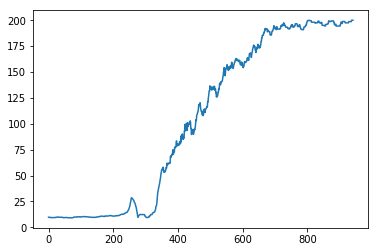

In [4]:
import matplotlib.pyplot as plt
plt.plot(running_mean(episode_callback.episode_rewards,20))
plt.show()

## Redes neuronales: DeepSarsa

In [21]:
ENV_NAME = 'CartPole-v0'
# Get the environment and extract the number of actions.
env = gym.make(ENV_NAME)
#np.random.seed(123)
#env.seed(123)
nb_actions = env.action_space.n

# Next, we build a very simple model.
model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(4))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())

# Finally, we configure and compile our agent. You can use every built-in Keras optimizer and
# even the metrics!
policy = EpsGreedyQPolicy()

sarsa = SARSAAgent(model=model, nb_actions=nb_actions, nb_steps_warmup=10,
               policy=policy)
sarsa.compile(Adam(lr=1e-3), metrics=['mae'])

# Okay, now it's time to learn something! We visualize the training here for show, but this
# slows down training quite a lot. You can always safely abort the training prematurely using
# Ctrl + C.

sarsa.fit(env, nb_steps=int(1.5e3), visualize=False, verbose=2,callbacks=[episode_callback])

# After training is done, we save the final weights.
sarsa.save_weights('sarsa_{}_weights.h5f'.format(ENV_NAME), overwrite=True)

# Finally, evaluate our algorithm for 5 episodes.
sarsa.test(env, nb_episodes=5, visualize=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 4)                 0         
_________________________________________________________________
dense_17 (Dense)             (None, 4)                 20        
_________________________________________________________________
activation_17 (Activation)   (None, 4)                 0         
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 10        
_________________________________________________________________
activation_18 (Activation)   (None, 2)                 0         
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
None
Training for 1500 steps ...
Episode 1 reward: 10.0
   10/1500: episode: 1, duration: 0.495s, episode steps: 10, steps per second: 20, episode

Episode 28 reward: 11.0
  273/1500: episode: 28, duration: 0.047s, episode steps: 11, steps per second: 234, episode reward: 11.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.182 [0.000, 1.000], mean observation: 0.130 [-1.372, 2.345], loss: 0.772811, mean_absolute_error: 0.783680, mean_q: 0.753871
Episode 29 reward: 9.0
  282/1500: episode: 29, duration: 0.041s, episode steps: 9, steps per second: 218, episode reward: 9.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.000 [0.000, 0.000], mean observation: 0.160 [-1.715, 2.827], loss: 0.541124, mean_absolute_error: 0.769934, mean_q: 0.888394
Episode 30 reward: 10.0
  292/1500: episode: 30, duration: 0.033s, episode steps: 10, steps per second: 303, episode reward: 10.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.000 [0.000, 0.000], mean observation: 0.129 [-1.988, 3.035], loss: 0.564740, mean_absolute_error: 0.814539, mean_q: 0.949877
Episode 31 reward: 10.0
  302/1500: episode: 31, duration: 0.028s, episode step

Episode 58 reward: 10.0
  562/1500: episode: 58, duration: 0.036s, episode steps: 10, steps per second: 276, episode reward: 10.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.100 [0.000, 1.000], mean observation: 0.144 [-1.556, 2.556], loss: 1.413614, mean_absolute_error: 1.187848, mean_q: 2.223913
Episode 59 reward: 11.0
  573/1500: episode: 59, duration: 0.030s, episode steps: 11, steps per second: 366, episode reward: 11.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.091 [0.000, 1.000], mean observation: 0.143 [-1.717, 2.869], loss: 1.483813, mean_absolute_error: 1.118272, mean_q: 2.160661
Episode 60 reward: 10.0
  583/1500: episode: 60, duration: 0.026s, episode steps: 10, steps per second: 378, episode reward: 10.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.000 [0.000, 0.000], mean observation: 0.147 [-1.954, 3.103], loss: 0.959944, mean_absolute_error: 0.949870, mean_q: 2.301157
Episode 61 reward: 8.0
  591/1500: episode: 61, duration: 0.023s, episode st

Episode 91 reward: 11.0
  898/1500: episode: 91, duration: 0.036s, episode steps: 11, steps per second: 309, episode reward: 11.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.091 [0.000, 1.000], mean observation: 0.120 [-1.739, 2.798], loss: 2.448498, mean_absolute_error: 1.215451, mean_q: 3.481635
Episode 92 reward: 11.0
  909/1500: episode: 92, duration: 0.029s, episode steps: 11, steps per second: 377, episode reward: 11.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.000 [0.000, 0.000], mean observation: 0.123 [-2.180, 3.286], loss: 1.810357, mean_absolute_error: 0.912459, mean_q: 3.833843
Episode 93 reward: 12.0
  921/1500: episode: 93, duration: 0.029s, episode steps: 12, steps per second: 414, episode reward: 12.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.083 [0.000, 1.000], mean observation: 0.124 [-1.982, 3.090], loss: 2.528657, mean_absolute_error: 1.212978, mean_q: 3.710819
Episode 94 reward: 10.0
  931/1500: episode: 94, duration: 0.025s, episode s

Episode 122 reward: 11.0
 1215/1500: episode: 122, duration: 0.036s, episode steps: 11, steps per second: 308, episode reward: 11.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.000 [0.000, 0.000], mean observation: 0.148 [-2.138, 3.304], loss: 2.448105, mean_absolute_error: 1.055140, mean_q: 4.917461
Episode 123 reward: 10.0
 1225/1500: episode: 123, duration: 0.027s, episode steps: 10, steps per second: 376, episode reward: 10.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.000 [0.000, 0.000], mean observation: 0.139 [-1.935, 3.026], loss: 2.368006, mean_absolute_error: 1.082602, mean_q: 4.847666
Episode 124 reward: 8.0
 1233/1500: episode: 124, duration: 0.026s, episode steps: 8, steps per second: 306, episode reward: 8.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.000 [0.000, 0.000], mean observation: 0.157 [-1.590, 2.573], loss: 2.359500, mean_absolute_error: 1.068780, mean_q: 4.713131
Episode 125 reward: 10.0
 1243/1500: episode: 125, duration: 0.036s, epis

Testing for 5 episodes ...
Episode 1: reward: 10.000, steps: 10
Episode 2: reward: 8.000, steps: 8
Episode 3: reward: 8.000, steps: 8
Episode 4: reward: 10.000, steps: 10
Episode 5: reward: 10.000, steps: 10


In [22]:
print("All episode rewards:", episode_callback.episode_rewards)

All episode rewards: [9.0, 10.0, 9.0, 10.0, 10.0, 9.0, 10.0, 9.0, 10.0, 10.0, 9.0, 11.0, 10.0, 8.0, 9.0, 10.0, 10.0, 9.0, 10.0, 10.0, 9.0, 10.0, 11.0, 12.0, 12.0, 9.0, 10.0, 9.0, 10.0, 8.0, 10.0, 10.0, 10.0, 9.0, 9.0, 14.0, 11.0, 10.0, 10.0, 11.0, 10.0, 11.0, 11.0, 10.0, 9.0, 10.0, 9.0, 12.0, 8.0, 9.0, 9.0, 8.0, 10.0, 16.0, 10.0, 13.0, 9.0, 10.0, 9.0, 8.0, 9.0, 10.0, 10.0, 9.0, 9.0, 9.0, 9.0, 9.0, 10.0, 10.0, 11.0, 9.0, 10.0, 10.0, 10.0, 12.0, 8.0, 8.0, 9.0, 10.0, 10.0, 11.0, 12.0, 9.0, 9.0, 8.0, 10.0, 9.0, 12.0, 12.0, 9.0, 9.0, 10.0, 8.0, 9.0, 12.0, 10.0, 12.0, 8.0, 9.0, 9.0, 10.0, 9.0, 10.0, 10.0, 10.0, 11.0, 9.0, 12.0, 11.0, 9.0, 10.0, 12.0, 10.0, 9.0, 11.0, 10.0, 11.0, 9.0, 8.0, 9.0, 12.0, 12.0, 9.0, 12.0, 8.0, 12.0, 9.0, 11.0, 9.0, 9.0, 15.0, 9.0, 9.0, 10.0, 9.0, 11.0, 9.0, 10.0, 9.0, 9.0, 10.0, 11.0, 15.0, 10.0, 10.0, 10.0, 10.0, 9.0, 9.0, 9.0, 10.0, 10.0, 9.0, 10.0, 11.0, 10.0, 10.0, 10.0, 13.0, 12.0, 8.0, 8.0, 12.0, 10.0, 10.0, 10.0, 10.0, 8.0, 10.0, 10.0, 10.0, 10.0, 9.0, 10.0

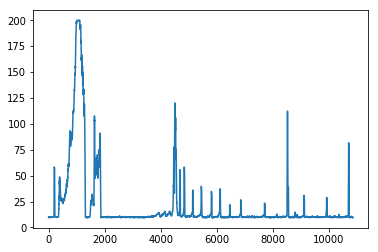

In [26]:
import matplotlib.pyplot as plt
plt.plot(running_mean(episode_callback.episode_rewards,20))
plt.show()

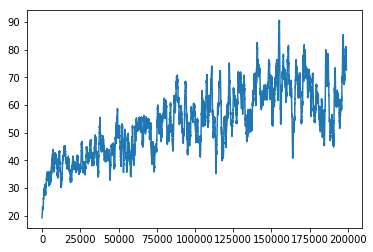

In [82]:
plt.plot(running_mean(Gs,1000))
plt.show()

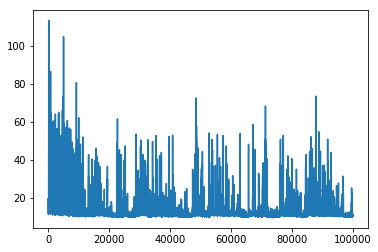

In [65]:
import matplotlib.pyplot as plt
plt.plot(running_mean(Gs,20))
plt.show()

In [86]:
for state_4096 in states_4096:
    policy[state_4096],_=eps_greedy(Q,tuple(state_4096),0)

In [87]:
rwds=[]
for _ in range(100):
    observation = env.reset()
    r=0
    while True:
        action = policy[discretize_4096(observation)]
        env.render(mode='human')
        observation, reward, terminated, truncated = env.step(action)
        r+=reward

        if terminated or truncated:
            observation = env.reset()
            rwds.append(r)
            break
env.close()
print(np.mean(rwds))

24.41


In [40]:
env.close()

_------------------------------------------------------------------_

#### Apéndice

In [8]:

ENV_NAME = 'CartPole-v1'


# Get the environment and extract the number of actions.
env = gym.make(ENV_NAME)

nb_actions = env.action_space.n

model = Sequential(
    [
        Flatten(input_shape=(1,) + env.observation_space.shape),
        Dense(16, activation="relu"),
        Dense(2, activation="linear"),
    ]
)


print(model.summary())

policy = EpsGreedyQPolicy()

memory = SequentialMemory(limit=50000, window_length=1)

dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=10,
               target_model_update=1e-2, policy=policy)

dqn.compile(Adam(learning_rate=1e-3), metrics=['mae'])

dqn.fit(env, nb_steps=100, visualize=True, verbose=2)

visualkeras.layered_view(model)

dqn.save_weights('dqn_{}_weights.h5f'.format(ENV_NAME), overwrite=True)

# Finally, evaluate our algorithm for 5 episodes.
dqn.test(env, nb_episodes=5, visualize=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 4)                 0         
                                                                 
 dense_2 (Dense)             (None, 16)                80        
                                                                 
 dense_3 (Dense)             (None, 2)                 34        
                                                                 
Total params: 114
Trainable params: 114
Non-trainable params: 0
_________________________________________________________________
None
Training for 100 steps ...


ValueError: Error when checking input: expected flatten_1_input to have shape (1, 4) but got array with shape (1, 2)

## SARSA con 400 estados:

In [ ]:
'''

#SARSA algorithm
def SARSA_400(gamma, alpha):
    allowed_actions=[0,1]
    cont = 0
    #Para 5000 episodios de entrenamiento
    for i in range(num_episodes):
        # Inicializa las variables para cada episodio
        state=env.reset()
        num_steps = 0
        state = discretize(state[0])


        # Seleccion accion "a" de forma epsilon-greedy
        action,_ = eps_greedy(Q_, state,epsilon=0.1)

        # Inicia el episodio
        continue_episode = True
        while continue_episode:        
            # Obtengo s'
            new_state, reward, done, _,_=env.step(action)
            new_state = discretize(new_state)

            # Revisa que new_state no sea un estado terminal
            if done:
                # Valor q(s',a') terminal
                q_value_next_step = 0
            else:
                #Obtengo a' de s' con epsilon greedy
                if epsilon< np.random.uniform():        
                    act_arg = np.array([Q_table[tuple(state), act] for act in range(2)])
                    new_action = allowed_actions[np.argmax(act_arg)]
                else:
                    new_action = env.action_space.sample()

                # Valor q(s',a') no terminal
                q_value_next_step = Q_table[tuple(new_state),new_action]


            # Calculo de actualizacion q(s,a) <- q(s,a) + alpha*(R + gamma*q(s',a') - q(s,a))
            Q_table[tuple(state), action] += alpha*(reward + gamma*q_value_next_step - Q_table[tuple(state),action])

            # asigna a = a' y s = s'
            state = new_state
            action = new_action


            # Parte que termina el episodio si se llega a algun estado terminal
            if done:
                continue_episode = False
        cont+=1
        if cont%100==0:
            print(cont)
'''

In [ ]:
set_states()
set_q_table()

In [ ]:
discrete_values = num_states(400)
SARSA_algorithm(5000)

In [ ]:
allowed_actions= [0,1]
prom=[]
prom_rand=[]
for i in range(100):
    G_pi = 0
    state =env.reset()
    state = state[0]
    state = discretize(state)
    act_arg = np.array([Q_table[tuple(state), act] for act in range(2)])
    action = allowed_actions[np.argmax(act_arg)]
    done = False
    n=1
    while not done:
        new_state, reward, done, _,_=env.step(action)
        G_pi= G_pi + reward
        discrete_state = discretize(new_state)
        act_arg = np.array([Q_table[tuple(discrete_state), act] for act in range(2)])
        action = allowed_actions[np.argmax(act_arg)]
    prom.append(G_pi)
print('---'*5)
for i in range(100):
    G_pi = 0
    state =env.reset()
    done = False
    while not done:
        action = env.action_space.sample()
        new_state, reward, done, _,_=env.step(action)
        G_pi= G_pi + reward
    prom_rand.append(G_pi)

In [ ]:
print("Retorno obtenido con la funcion q:",sum(prom)/len(prom))
print("Retorno obtenido de acciones al azar:",sum(prom_rand)/len(prom_rand))

## SARSA con 4000 estados:

In [ ]:
set_states()
set_q_table()

In [ ]:
discrete_values = num_states(4000)
SARSA_algorithm(1000)

In [ ]:
prom=[]
prom_rand=[]
allowed_actions= [0,1]
for i in range(100):
    G_pi = 0
    state =env.reset()
    state = state[0]
    state = discretize(state)
    act_arg = np.array([Q_table[tuple(state), act] for act in range(2)])
    action = allowed_actions[np.argmax(act_arg)]
    done = False
    n=1
    while not done:
        new_state, reward, done, _,_=env.step(action)
        G_pi= G_pi + reward
        discrete_state = discretize(new_state)
        act_arg = np.array([Q_table[tuple(discrete_state), act] for act in range(2)])
        action = allowed_actions[np.argmax(act_arg)]
    prom.append(G_pi)
print('---'*5)
for i in range(100):
    G_pi = 0
    state =env.reset()
    done = False
    while not done:
        action = env.action_space.sample()
        new_state, reward, done, _,_=env.step(action)
        G_pi= G_pi + reward
    prom_rand.append(G_pi)

In [ ]:
print("Retorno obtenido con la funcion q:",sum(prom)/len(prom))
print("Retorno obtenido de acciones al azar:",sum(prom_rand)/len(prom_rand))

In [ ]:
env.close()